In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

import sys
import os

from scipy import stats

In [2]:
def opening_input():
    user_input = input("Enter the path of your file: ")
    xls = pd.ExcelFile(user_input)
    scenarios = pd.read_excel(xls, 'Scenarios', index_col='Quartely')
    dq = pd.read_excel(xls, 2, index_col='Quartely')
    dq = dq.drop(columns = ['R0R4_6M', 'R0R4_12M'])
    dq['Q'] = dq.index
    dq['Y'] = dq.index
    dq['Q'] = dq['Q'].str[2:]
    dq['Y'] = dq['Y'].str[:-2]
    dq['ind'] = dq['Q'] + ' ' + dq['Y']
    dq = dq.set_index('ind')
    dq = dq.drop(columns=['Q'])
    dq = dq.drop(columns=['Y'])
    dq['k1'] = dq.index
    fav = scenarios.loc[scenarios['Model'] == 'Favourable']
    fav = fav.drop(columns=['Model'])
    base = scenarios.loc[scenarios['Model'] == 'Baseline']
    base = base.drop(columns=['Model'])
    adve = scenarios.loc[scenarios['Model'] == 'Adversed']
    adve = adve.drop(columns=['Model'])
    base['k1'] = base.index
    fav['k1'] = fav.index
    adve['k1'] = adve.index
    base['k1'] = base['k1'].str.strip()
    fav['k1'] = fav['k1'].str.strip()
    adve['k1'] = adve['k1'].str.strip()
    dq['k1'] = dq['k1'].str.strip()
    
    user_input_scenario = input("Enter scenario base, fav or adve: ")

    if user_input_scenario == 'base':
        actuals_input = base
    elif user_input_scenario == 'fav':
        actuals_input = fav
    else:
        actuals_input = adve
        
    actuals = pd.merge(dq,actuals_input, how="inner", left_on='k1', right_on='k1')
    actuals = actuals.set_index('k1')
    actuals = pd.DataFrame(actuals)
    actuals.to_csv ('actuals.csv', index = True, header=True) 
    m_forecast = pd.merge(dq,actuals_input, how="right", left_on='k1', right_on='k1')
    m_forecast = pd.DataFrame(m_forecast)
    loc_index = int(m_forecast['R0R4_3M'].notna().idxmax())
    m_forecast = m_forecast.iloc[loc_index:]
    m_forecast.to_csv ('m_forecast.csv', index = True, header=True) 
    return actuals, m_forecast

In [3]:
actuals, m_forecast = opening_input()

Enter the path of your file:  /Users/pablogtorres/Bootcamp/Module2/Project/stats.xls
Enter scenario base, fav or adve:  base


In [4]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
    
grangers_causation_matrix(actuals, variables = actuals.columns)

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def pre_model(actuals):
    from statsmodels.tsa.stattools import grangercausalitytests

    maxlag=12
    test = 'ssr_chi2test'

    def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
        """Check Granger Causality of all possible combinations of the Time series.
        The rows are the response variable, columns are predictors. The values in the table 
        are the P-Values. P-Values lesser than the significance level (0.05), implies 
        the Null Hypothesis that the coefficients of the corresponding past values is 
        zero, that is, the X does not cause Y can be rejected.

        data      : pandas dataframe containing the time series variables
        variables : list containing names of the time series variables.
        """
        df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in df.columns:
            for r in df.index:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
        df.columns = [var + '_x' for var in variables]
        df.index = [var + '_y' for var in variables]
        return df
    
    grangers_causation_matrix(actuals, variables = actuals.columns)
    
    from statsmodels.tsa.vector_ar.vecm import coint_johansen


    def cointegration_test(df, alpha=0.05): 
        """Perform Johanson's Cointegration Test and Report Summary"""
        out = coint_johansen(df,-1,5)
        d = {'0.90':0, '0.95':1, '0.99':2}
        traces = out.lr1
        cvts = out.cvt[:, d[str(1-alpha)]]
        def adjust(val, length= 6): return str(val).ljust(length)

        # Summary
        print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
        for col, trace, cvt in zip(df.columns, traces, cvts):
            print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

    cointegration_test(actuals)
    
    #Testing for stationary:

    def adfuller_test(series, signif=0.05, name='', verbose=False):
        """Perform ADFuller to test for Stationarity of given series and print report"""
        r = adfuller(series, autolag='AIC')
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue'] 
        def adjust(val, length= 6): return str(val).ljust(length)

        # Print Summary
        print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
        print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
        print(f' Significance Level    = {signif}')
        print(f' Test Statistic        = {output["test_statistic"]}')
        print(f' No. Lags Chosen       = {output["n_lags"]}')

        for key,val in r[4].items():
            print(f' Critical value {adjust(key)} = {round(val, 3)}')

        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")  
    
    
    # ADF Test on each column
    for name, column in actuals.iteritems():
        adfuller_test(column, name=column.name)
        print('\n')
        
    #Chose the stationary level:
    user_input_stationary = input("Is the level of stational series satisfactory? ")
    while user_input_stationary != 'y':
        actuals = actuals.diff().dropna()
        for name, column in actuals.iteritems():
            adfuller_test(column, name=column.name)
            print('\n')
        user_input_stationary = input("Is the level of stational series satisfactory? ")
    actuals.to_csv ('actuals_tested.csv', index = True, header=True) 
    return actuals

actuals = pre_model(actuals)

def modeling(actuals):
    model = VAR(actuals)
    x = model.select_order(maxlags=5)
    y = pd.DataFrame(x.summary())
    y = y.rename(columns=y.iloc[0]).drop(y.index[0])
    y.drop(y.columns[0], axis=1, inplace=True)
    cols = ['AIC', 'BIC', 'FPE', 'HQIC']
    y.columns = cols
    positions = []
    for i in y.columns:
        for m in range(1,len(y[i])+1):
            if y[i][m].__dict__['data'].find('*') == 10:
                positions.append(m)
    mode_lag = int(stats.mode(positions)[0])
    model_fitted = model.fit(mode_lag)
    parameters = model_fitted.params
    parameters = parameters['R0R4_3M']
    parameters = pd.DataFrame(parameters)
    # Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
    from statsmodels.stats.stattools import durbin_watson
    out = durbin_watson(model_fitted.resid)
    for col, val in zip(actuals.columns, out):
        print(col, ':', round(val, 2))
    parameters.to_csv ('parameters.csv', index = True, header=True) 
    return mode_lag, parameters
    
mode_lag, parameters = modeling(actuals)

def var_forecast(parameters, m_forecast):
    m_forecast = m_forecast.drop(columns='k1')
    maxlag = mode_lag
    factors = int(len(m_forecast.columns))
    parameters_k = parameters.iloc[:1]
    col_k = list(parameters_k.columns)
    col_sel_k = col_k[0]
    parameters_k = parameters_k[col_sel_k].tolist()
    parameters_v = parameters.iloc[1:]
    col_v = list(parameters_v.columns)
    col_sel = col_v[0]
    parameters_v = parameters_v[col_sel].tolist()
    numerical = []
    for i in range(1,maxlag+1):
        for m in range(1, (factors)+1):
            numerical.append('b'+'_Lag'+str(i)+'_Col'+str(m))
    d1 = dict(zip(numerical,parameters_v))
    col_regresors = list(m_forecast.columns)
    col_regresors = col_regresors*10
    d2 = {}
    for i in range(len(numerical)):
        d2[numerical[i]] = col_regresors[i]
    for i in m_forecast['R0R4_3M']:
        if (m_forecast['R0R4_3M'].isna().idxmax() != 0) and (m_forecast['R0R4_3M'].isna().idxmax() > m_forecast['R0R4_3M'].idxmax()):
            z = int(m_forecast['R0R4_3M'].isna().idxmax())
            values = []
            test_col = []
            for t in range(1,maxlag+1):
                cond = 'Lag'+str(t)
                for k in d2.keys():
                    if cond in k:
                        equ = m_forecast[d2[k]][z-t]*d1[k]
                        values.append(equ)
            m_forecast['R0R4_3M'][z] = sum(values) + parameters_k
    # Plot Selected scenario:
    fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = m_forecast[m_forecast.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(m_forecast.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout(); 
    return m_forecast




,R0R4_3M_x,"UK, GDP (q/q)_x","UK, GDP (y/y)_x","UK, unemployment rate_x","UK, inflation (HICP)_x","UK, home prices (y/y)_x"
R0R4_3M_y,1.0000,0.0,0.0,0.0007,0.0001,0.0001
"UK, GDP (q/q)_y",0.0000,1.0,0.0,0.0000,0.0020,0.0000
"UK, GDP (y/y)_y",0.0006,0.0,1.0,0.0000,0.0000,0.0000
"UK, unemployment rate_y",0.0000,0.0,0.0,1.0000,0.0000,0.0000
"UK, inflation (HICP)_y",0.0018,0.0,0.0,0.0000,1.0000,0.0000
"UK, home prices (y/y)_y",0.0000,0.0,0.0,0.0000,0.0000,1.0000


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
R0R4_3M ::  307.75    > 83.9383   =>   True
UK, GDP (q/q) ::  206.26    > 60.0627   =>   True
UK, GDP (y/y) ::  135.14    > 40.1749   =>   True
UK, unemployment rate ::  71.82     > 24.2761   =>   True
UK, inflation (HICP) ::  30.61     > 12.3212   =>   True
UK, home prices (y/y) ::  13.31     > 4.1296    =>   True


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
R0R4_3M ::  307.75    > 83.9383   =>   True
UK, GDP (q/q) ::  206.26    > 60.0627   =>   True
UK, GDP (y/y) ::  135.14    > 40.1749   =>   True
UK, unemployment rate ::  71.82     > 24.2761   =>   True
UK, inflation (HICP) ::  30.61     > 12.3212   =>   True
UK, home prices (y/y) ::  13.31     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "R0R4_3M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3079
 No. Lags Chosen       = 0
 Critical value 1%     = -3.571
 Critical value 5%     = -2.923
 Critical value 10%    = -2.599
 => P-Value = 0.1694. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "UK, GDP (q/q)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

Is the level of stational series satisfactory?  n


    Augmented Dickey-Fuller Test on "R0R4_3M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.8541
 No. Lags Chosen       = 0
 Critical value 1%     = -3.575
 Critical value 5%     = -2.924
 Critical value 10%    = -2.6
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "UK, GDP (q/q)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.6087
 No. Lags Chosen       = 2
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.9979. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "UK, GDP (y/y)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

Is the level of stational series satisfactory?  n


    Augmented Dickey-Fuller Test on "R0R4_3M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.4983
 No. Lags Chosen       = 1
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "UK, GDP (q/q)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.2613
 No. Lags Chosen       = 3
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.9964. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "UK, GDP (y/y)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

Is the level of stational series satisfactory?  y


R0R4_3M : 1.74
UK, GDP (q/q) : 2.16
UK, GDP (y/y) : 2.16
UK, unemployment rate : 2.56
UK, inflation (HICP) : 2.3
UK, home prices (y/y) : 1.46


/Users/pablogtorres/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


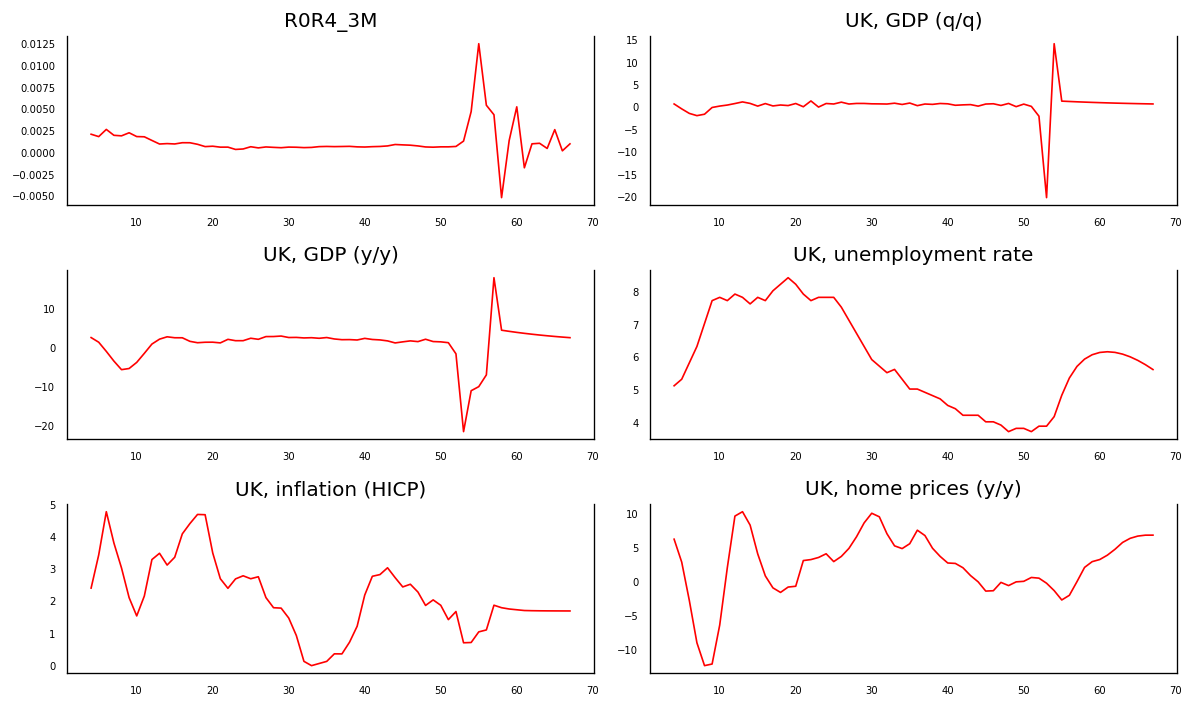

In [18]:
m_forecast = var_forecast(parameters, m_forecast)